<a href="https://colab.research.google.com/github/Lefkios/yolov8-adversarial-patch-defense/blob/main/yolo_multifolder_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convert COCO Annotations to YOLO Format (per folder)

This cell loads COCO-style annotations and converts them into YOLO format for each folder in a list (e.g., billboard scenarios).

### What it does:
- Reads COCO `.json` annotation files (`coco_annotations.json`)
- For each image:
  - Converts each bounding box from COCO format `(x, y, width, height)` to YOLO format `(x_center, y_center, width, height)` — normalized by image size
  - Saves the results in `.txt` files with the same name as the image (but `.txt` extension)
- Creates the `labels/{subset}` directory if it doesn't exist
- Skips images with no annotations



In [ ]:
from pycocotools.coco import COCO
import os

nc = 80
def convert_bbox_to_yolo(image_width, image_height, bbox):
    x, y, w, h = bbox
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    w = w / image_width
    h = h / image_height
    return x_center, y_center, w, h

def convert_coco_to_yolo_per_folder(dataset_root, billboard_folders, subset="train", nc=80):
    for folder in billboard_folders:
        ann_path = os.path.join(dataset_root, folder, "annotations", subset, "coco_annotations.json")
        coco = COCO(ann_path)

        # Create mapping: COCO category ID -> index 0–79
        cats = coco.loadCats(coco.getCatIds())
        coco_id_to_yolo_id = {cat['id']: i for i, cat in enumerate(sorted(cats, key=lambda c: c['id']))}

        label_dir = os.path.join(dataset_root, folder, "labels", subset)
        os.makedirs(label_dir, exist_ok=True)

        for img_id in coco.getImgIds():
            img = coco.loadImgs([img_id])[0]
            anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

            if not anns:
                continue

            label_lines = []
            for ann in anns:
                if 'bbox' not in ann or ann['category_id'] not in coco_id_to_yolo_id:
                    continue

                yolo_bbox = convert_bbox_to_yolo(img["width"], img["height"], ann["bbox"])
                class_id = coco_id_to_yolo_id[ann["category_id"]]  #  mapped class ID
                label_lines.append(f"{class_id} {' '.join(map(str, yolo_bbox))}")

            label_filename = img["file_name"].rsplit(".", 1)[0] + ".txt"
            label_path = os.path.join(label_dir, label_filename)

            with open(label_path, "w") as f:
                f.write("\n".join(label_lines))

        print(f"{folder}: YOLO labels saved to {label_dir}")


#Create Image List File for YOLO Training (`train.txt`, `val.txt`, etc.)

This cell creates a plain `.txt` file listing all image paths in the dataset — one path per line — for a given subset (`train`, `val`, or `test`).


### Output:
- A file like `train.txt` or `val.txt` saved in the dataset root
- This is used by YOLOv5/v8 to know which images to load for training/validation

In [ ]:
def create_image_txt_list(dataset_root, billboard_folders, subset="train"):
    txt_path = os.path.join(dataset_root, f"{subset}.txt")
    with open(txt_path, "w") as f:
        for bb in billboard_folders:
            image_dir = os.path.join(dataset_root, bb, "images", subset)
            if not os.path.exists(image_dir):
                print(f"Skipping missing image dir: {image_dir}")
                continue

            for img_name in sorted(os.listdir(image_dir)):
                if img_name.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(image_dir, img_name)
                    f.write(img_path + "\n")
    print(f"{subset}.txt created at: {txt_path}")


This cell calls the convert_coco_to_yolo_per_folder and create_image_txt_list functions to generate YOLO-format label files and a train.txt/val.txt file listing all training/validation image paths.

In [ ]:

dataset_root = "/content/drive/MyDrive/2dod/2dod"
billboards = ["billboard01", "billboard02", "billboard03", "billboard04",
              "billboard05", "billboard06", "billboard07", "billboard08", "billboard09"]

# Convert both train and val annotations
convert_coco_to_yolo_per_folder(dataset_root, billboards, subset="train")
convert_coco_to_yolo_per_folder(dataset_root, billboards, subset="val")

# Create train.txt and val.txt
create_image_txt_list(dataset_root, billboards, subset="train")
create_image_txt_list(dataset_root, billboards, subset="val")


loading annotations into memory...
Done (t=1.65s)
creating index...
index created!
billboard01: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard01/labels/train
loading annotations into memory...
Done (t=1.73s)
creating index...
index created!
billboard02: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard02/labels/train
loading annotations into memory...
Done (t=1.87s)
creating index...
index created!
billboard03: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard03/labels/train
loading annotations into memory...
Done (t=1.25s)
creating index...
index created!
billboard04: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard04/labels/train
loading annotations into memory...
Done (t=1.64s)
creating index...
index created!
billboard05: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard05/labels/train
loading annotations into memory...
Done (t=1.74s)
creating index...
index created!
billboard06: YOLO labels saved to /content

# 📄 Generate `data.yaml` for YOLOv8 Training

This cell creates the `data.yaml` file, which is required by YOLOv8 for training.

### What it defines:
- **train**: path to the `train.txt` file that lists all training image paths
- **val**: path to the `val.txt` file (currently set to the same as train — update if needed)
- **nc**: number of classes (80 for COCO)
- **names**: a dictionary mapping class IDs to class names, based on the COCO dataset


In [ ]:
data_yaml_path = "/content/drive/MyDrive/2dod/2dod/data.yaml"

data_yaml_content = """\
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
nc: 80
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open(data_yaml_path, "w") as f:
    f.write(data_yaml_content)

print(f" data.yaml saved at: {data_yaml_path}")


 data.yaml saved at: /content/drive/MyDrive/2dod/2dod/data.yaml


Verify that the annotations are converted correclty

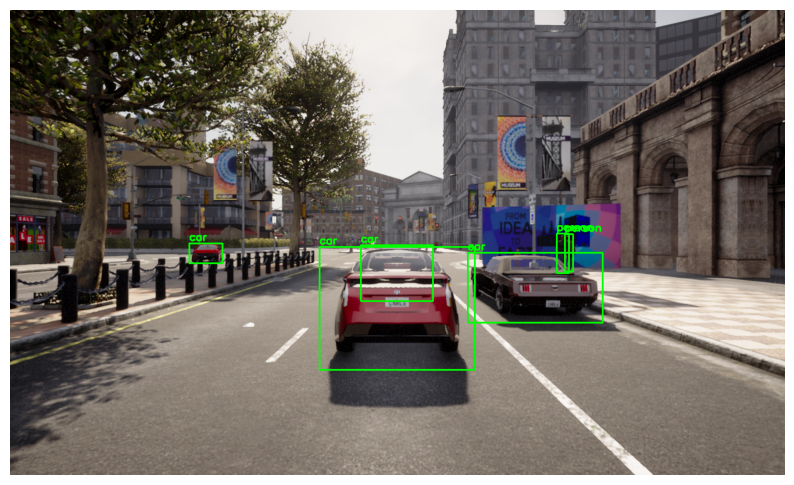

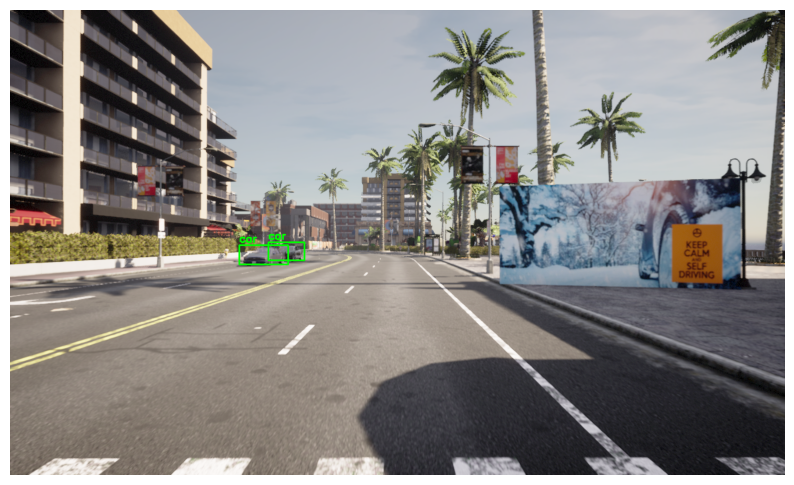

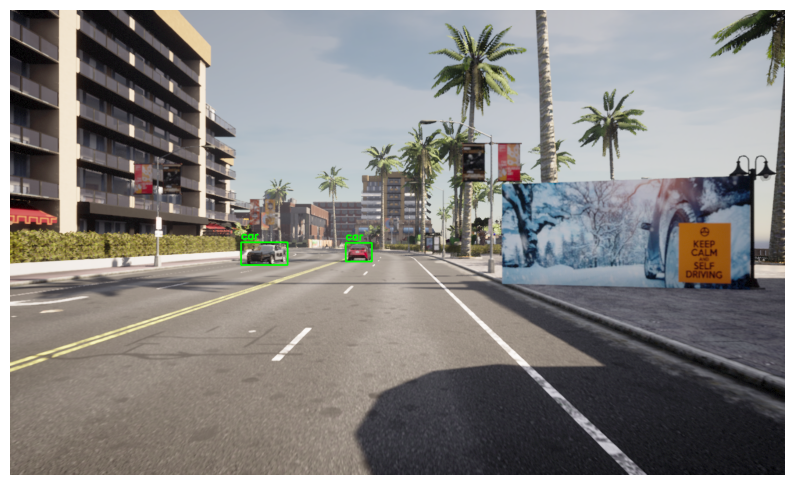

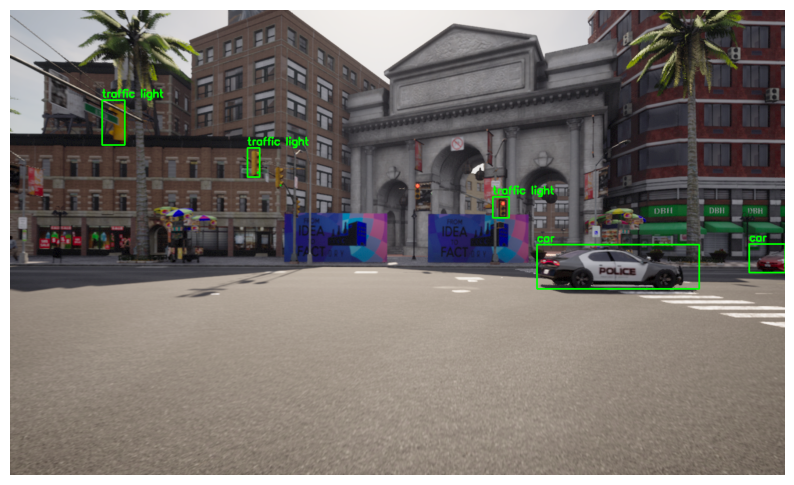

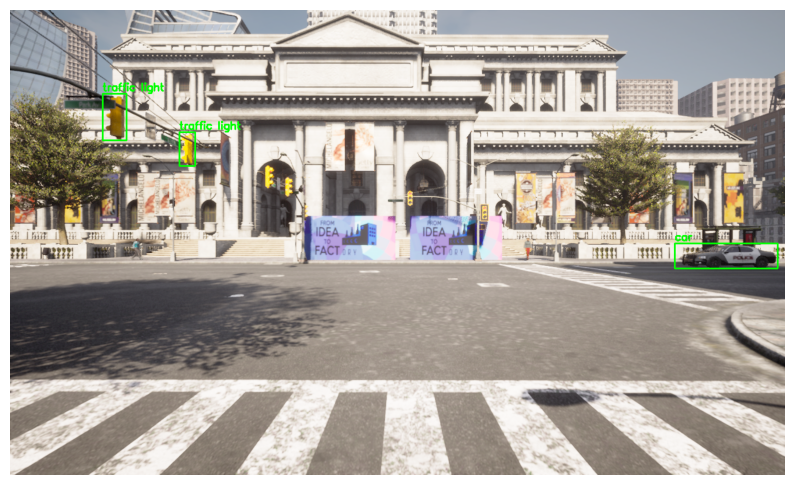

In [ ]:
# Visualize YOLO bounding boxes (from train.txt) using full COCO class list

import cv2
import os
import random
import matplotlib.pyplot as plt

# Full COCO 80 class names
class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

def visualize_yolo_label(img_path, label_path, class_names):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        return

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id = int(parts[0])
            x_c, y_c, bw, bh = map(float, parts[1:])

            # Convert YOLO (normalized) to pixel box
            x1 = int((x_c - bw / 2) * w)
            y1 = int((y_c - bh / 2) * h)
            x2 = int((x_c + bw / 2) * w)
            y2 = int((y_c + bh / 2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = class_names[class_id] if class_id < len(class_names) else str(class_id)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

#  Load 5 random samples from train.txt
dataset_root = "/content/drive/MyDrive/2dod/2dod"
train_txt = os.path.join(dataset_root, "train.txt")

with open(train_txt, "r") as f:
    image_paths = [line.strip() for line in f if line.strip()]

for img_path in random.sample(image_paths, 5):
    label_path = img_path.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    visualize_yolo_label(img_path, label_path, class_names)



In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Train YOLOv8 on Custom Dataset


In [ ]:
model = YOLO("yolov8m.pt")

# Continue training from that checkpoint
model.train(
    data="/content/drive/MyDrive/2dod/2dod/data.yaml",
    epochs=200,
    imgsz=640,
    batch=8,
    save_period=100,
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 243MB/s]


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/2dod/2dod/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3822016  ultralytics.nn.modules.head.Detect           [80, [192, 384, 576]]         
Model summary: 169 layers, 25,902,640 parameters, 25,902,624 gradients, 79.3 GFLOPs

Transferred 475/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 400MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 1315.0±247.5 ms, read: 1.5±0.3 MB/s, size: 1707.0 KB)


train: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/train.cache... 839 images, 61 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 1.6±0.2 MB/s, size: 1650.9 KB)


val: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/val.cache... 424 images, 26 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.49G      1.744       1.18      1.268         26        640: 100%|██████████| 113/113 [01:44<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.69it/s]

                   all        450       1856      0.777       0.65      0.699      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.69G      1.407     0.8241      1.062         39        640: 100%|██████████| 113/113 [00:11<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.59it/s]

                   all        450       1856      0.794      0.746      0.784      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.72G      1.283     0.7629      1.006         38        640: 100%|██████████| 113/113 [00:11<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.30it/s]

                   all        450       1856      0.795      0.783      0.795      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.79G       1.21      0.728     0.9916         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.45it/s]

                   all        450       1856       0.83      0.768      0.826      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.82G      1.147     0.6783     0.9608         42        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.99it/s]

                   all        450       1856      0.838      0.794      0.832      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.82G      1.123     0.6642     0.9544         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.96it/s]

                   all        450       1856      0.835      0.807      0.868      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.82G      1.093     0.6439     0.9442         28        640: 100%|██████████| 113/113 [00:10<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.06it/s]

                   all        450       1856       0.83      0.838      0.875      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.84G      1.032     0.5926     0.9228         31        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.19it/s]

                   all        450       1856      0.833      0.851      0.882       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200         4G      1.046     0.5978     0.9256         38        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.44it/s]

                   all        450       1856       0.81      0.859      0.882      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.15G      1.016      0.589     0.9205         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.19it/s]

                   all        450       1856      0.898      0.818      0.896       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.27G     0.9802     0.5724     0.9104         37        640: 100%|██████████| 113/113 [00:10<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.75it/s]

                   all        450       1856      0.841      0.866      0.901       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.27G     0.9817     0.5753     0.9087         50        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.54it/s]

                   all        450       1856      0.865      0.855      0.898      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.27G      0.958     0.5558      0.901         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.71it/s]

                   all        450       1856      0.856      0.878      0.902      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.27G     0.9625     0.5533     0.9051         29        640: 100%|██████████| 113/113 [00:10<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.26it/s]

                   all        450       1856      0.921      0.846      0.904       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.27G     0.9479     0.5463     0.9007         44        640: 100%|██████████| 113/113 [00:11<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.71it/s]

                   all        450       1856      0.871      0.891      0.914      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.27G      0.942     0.5457     0.9055         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.74it/s]

                   all        450       1856      0.864      0.884      0.913      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.27G     0.9078     0.5268     0.8949         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.31it/s]

                   all        450       1856      0.893      0.875      0.918      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.27G     0.9031     0.5163     0.8919         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]

                   all        450       1856      0.867      0.876      0.916      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.27G     0.9161     0.5277     0.8904         37        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.57it/s]

                   all        450       1856      0.868      0.897      0.919      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.27G     0.8968     0.5159      0.883         35        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.74it/s]

                   all        450       1856      0.884       0.87       0.92       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.27G     0.8894     0.5104     0.8884         25        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.39it/s]

                   all        450       1856      0.876      0.895      0.924      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.27G     0.8865     0.5007     0.8866         50        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.30it/s]

                   all        450       1856      0.882      0.881      0.916       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.27G     0.8965     0.5207     0.8923         35        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all        450       1856      0.871      0.871      0.914      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.27G     0.8907     0.5103     0.8895         36        640: 100%|██████████| 113/113 [00:11<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.84it/s]

                   all        450       1856      0.876      0.894      0.916      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.27G     0.8573     0.4987     0.8816         43        640: 100%|██████████| 113/113 [00:11<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.84it/s]

                   all        450       1856       0.88      0.872        0.9      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.27G     0.8611     0.4913     0.8753         31        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.74it/s]

                   all        450       1856      0.875      0.882      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.27G     0.8328     0.4876     0.8712         44        640: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.06it/s]

                   all        450       1856      0.902      0.866      0.915      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.27G     0.8654     0.4896     0.8772         18        640: 100%|██████████| 113/113 [00:10<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856      0.907      0.862      0.918      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.27G     0.8392     0.4816      0.878         37        640: 100%|██████████| 113/113 [00:11<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.32it/s]

                   all        450       1856      0.897      0.874      0.904      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.27G     0.8245     0.4793      0.873         26        640: 100%|██████████| 113/113 [00:10<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.59it/s]

                   all        450       1856      0.903      0.859      0.907      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.27G     0.8128     0.4781     0.8622         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.89it/s]

                   all        450       1856      0.899      0.864      0.917      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.27G     0.8393     0.4805     0.8758         56        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.39it/s]

                   all        450       1856      0.877      0.886       0.92      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.27G     0.8077     0.4625     0.8657         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856      0.898      0.884      0.915      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.27G     0.8002     0.4636     0.8686         14        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.13it/s]

                   all        450       1856      0.896      0.869      0.905      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.27G     0.8212     0.4688     0.8691         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.28it/s]

                   all        450       1856      0.863       0.89      0.902      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.27G     0.8039      0.468     0.8663         19        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.39it/s]

                   all        450       1856      0.901      0.863      0.909      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.27G     0.7927     0.4593      0.861         26        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.40it/s]

                   all        450       1856      0.902      0.876      0.907      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.27G     0.7972     0.4575     0.8601         50        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.35it/s]

                   all        450       1856      0.885      0.887      0.906      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.27G     0.7683     0.4469     0.8582         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.51it/s]

                   all        450       1856      0.887      0.885      0.909       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.27G     0.7721      0.445     0.8578         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.02it/s]

                   all        450       1856      0.878      0.892      0.917      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.27G     0.7918     0.4529     0.8652         31        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.97it/s]

                   all        450       1856      0.889      0.877      0.913      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.27G     0.7596     0.4424     0.8555         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.46it/s]

                   all        450       1856      0.906      0.854      0.913      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.27G     0.7842     0.4564     0.8595         40        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.53it/s]

                   all        450       1856      0.882       0.87      0.903      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.27G     0.7833     0.4498     0.8625         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.35it/s]

                   all        450       1856      0.909      0.885      0.914      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.27G     0.7603     0.4392     0.8547         50        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all        450       1856      0.888      0.879       0.91      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.27G     0.7699     0.4464     0.8587         55        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.56it/s]

                   all        450       1856      0.912      0.872      0.914      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.27G     0.7499     0.4366     0.8568         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.13it/s]

                   all        450       1856      0.908       0.88      0.916      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.27G     0.7605     0.4381     0.8528         13        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.81it/s]

                   all        450       1856      0.883      0.877       0.91      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.27G      0.746     0.4368      0.847         30        640: 100%|██████████| 113/113 [00:11<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.72it/s]

                   all        450       1856      0.876      0.878      0.903      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.27G     0.7424     0.4389     0.8525         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]

                   all        450       1856       0.91      0.894      0.918      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.27G     0.7438     0.4264     0.8483         26        640: 100%|██████████| 113/113 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all        450       1856      0.907      0.888      0.924      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.27G      0.711     0.4168     0.8456         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.57it/s]

                   all        450       1856      0.905      0.881      0.919      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.27G      0.735     0.4256     0.8497         45        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.09it/s]

                   all        450       1856      0.896      0.881      0.917      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.27G     0.7217     0.4193     0.8506         19        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.01it/s]

                   all        450       1856      0.886      0.889      0.913      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.27G     0.7368     0.4216     0.8529         29        640: 100%|██████████| 113/113 [00:11<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.72it/s]

                   all        450       1856      0.872      0.892      0.917      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.27G     0.7355     0.4269     0.8521         11        640: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.74it/s]

                   all        450       1856      0.921       0.87      0.922        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.27G      0.734     0.4329     0.8532         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.69it/s]

                   all        450       1856      0.904      0.876      0.922      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.27G     0.7368     0.4298     0.8461         26        640: 100%|██████████| 113/113 [00:11<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]

                   all        450       1856      0.897      0.869      0.918      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.27G     0.7068     0.4171     0.8478         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856      0.887      0.894      0.919       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.27G     0.6988     0.4157     0.8441         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.97it/s]

                   all        450       1856      0.883      0.894      0.909        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.27G     0.7128     0.4112     0.8456         55        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.02it/s]

                   all        450       1856      0.909       0.86       0.91      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.27G     0.7149     0.4138     0.8489         25        640: 100%|██████████| 113/113 [00:10<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.00it/s]

                   all        450       1856       0.88      0.878      0.907      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.27G     0.6878     0.4051     0.8454         52        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.37it/s]

                   all        450       1856       0.92      0.867      0.916      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.27G     0.6993     0.4082     0.8454         54        640: 100%|██████████| 113/113 [00:11<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]

                   all        450       1856      0.899      0.895       0.92      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.27G     0.6943     0.4013     0.8394         36        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.61it/s]

                   all        450       1856      0.908      0.885      0.923      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.27G     0.6738     0.3963     0.8344         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.84it/s]

                   all        450       1856      0.904      0.886      0.918      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.27G     0.6734     0.3977     0.8383         43        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.22it/s]

                   all        450       1856      0.918      0.882      0.922      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.27G     0.6824     0.4004     0.8416         47        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.00it/s]

                   all        450       1856      0.881      0.887      0.913      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.27G     0.6851     0.3974     0.8394         23        640: 100%|██████████| 113/113 [00:10<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.44it/s]

                   all        450       1856      0.902      0.868      0.916      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.27G     0.6752        0.4     0.8416         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.63it/s]

                   all        450       1856      0.885      0.871      0.907      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.27G     0.6528     0.3892     0.8333         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.85it/s]

                   all        450       1856      0.887      0.882      0.909      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.27G     0.6733     0.3984     0.8425         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.69it/s]

                   all        450       1856      0.902      0.863       0.91       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.27G     0.6638     0.3907     0.8382         20        640: 100%|██████████| 113/113 [00:10<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]

                   all        450       1856      0.884      0.892      0.921      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.27G     0.6559     0.3911     0.8383         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.11it/s]

                   all        450       1856      0.891      0.872      0.923       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.27G     0.6474     0.3822     0.8371         23        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.02it/s]

                   all        450       1856      0.899      0.876      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.27G     0.6346     0.3791     0.8348         19        640: 100%|██████████| 113/113 [00:10<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all        450       1856      0.895        0.9      0.927      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.27G     0.6375     0.3845     0.8333         12        640: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]

                   all        450       1856      0.886       0.89      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.27G     0.6348     0.3793     0.8362         17        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.53it/s]

                   all        450       1856      0.905      0.885      0.918      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.27G     0.6378     0.3789     0.8333         31        640: 100%|██████████| 113/113 [00:10<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.76it/s]

                   all        450       1856      0.871      0.904      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.27G     0.6273     0.3726     0.8333         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.87it/s]

                   all        450       1856       0.88      0.901      0.922      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.27G     0.6443     0.3829     0.8329         27        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.88it/s]

                   all        450       1856        0.9       0.88      0.918      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.27G     0.6294     0.3702     0.8367         38        640: 100%|██████████| 113/113 [00:11<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.26it/s]

                   all        450       1856      0.919      0.874       0.92      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.27G     0.6346     0.3812     0.8304         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]

                   all        450       1856      0.888       0.89      0.914      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.27G     0.6455      0.384     0.8374         31        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.99it/s]

                   all        450       1856      0.912      0.887      0.916      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.27G     0.6287     0.3712     0.8255         26        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]

                   all        450       1856      0.914      0.859      0.914      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.27G     0.6181     0.3671     0.8332         13        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.49it/s]

                   all        450       1856      0.894       0.88      0.918      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.27G     0.6291     0.3735     0.8306         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.41it/s]

                   all        450       1856      0.892      0.896      0.919      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.27G     0.6082     0.3622     0.8247         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.73it/s]

                   all        450       1856      0.907      0.868      0.913      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.27G     0.6188     0.3682     0.8301         12        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856      0.911      0.881      0.913      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.27G     0.6182     0.3665     0.8286         36        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.50it/s]

                   all        450       1856      0.908      0.863      0.911      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.27G     0.6105     0.3651     0.8299         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.95it/s]

                   all        450       1856      0.882       0.88      0.912      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.27G     0.5919     0.3534     0.8224         32        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.71it/s]

                   all        450       1856      0.912      0.871      0.919      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.27G     0.5911     0.3542     0.8232         30        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856      0.906      0.885       0.92      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.27G     0.6024     0.3583     0.8216         14        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.24it/s]

                   all        450       1856        0.9      0.888      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.27G     0.6036     0.3607     0.8273         37        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.09it/s]

                   all        450       1856      0.899      0.879      0.917      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.27G     0.5922     0.3517     0.8212         21        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]

                   all        450       1856      0.896      0.881      0.914      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.27G      0.589     0.3496     0.8237         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.73it/s]

                   all        450       1856      0.909      0.876      0.912      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.27G      0.575     0.3517     0.8237         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.79it/s]

                   all        450       1856      0.901      0.881       0.92      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.27G     0.5905     0.3531     0.8237         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.83it/s]

                   all        450       1856      0.924      0.862      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.27G     0.5784     0.3419     0.8247         17        640: 100%|██████████| 113/113 [00:10<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.03it/s]

                   all        450       1856      0.913      0.879       0.92      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.27G     0.5728       0.34     0.8243         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.40it/s]

                   all        450       1856      0.917      0.869      0.922      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.27G     0.5802     0.3519     0.8245         26        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.15it/s]

                   all        450       1856      0.896      0.873      0.916      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.27G     0.5762     0.3434     0.8192         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.49it/s]

                   all        450       1856       0.91      0.878      0.922       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.27G     0.5912     0.3555     0.8229         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.70it/s]

                   all        450       1856       0.88      0.888      0.916      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.27G     0.5693     0.3419     0.8139         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.45it/s]

                   all        450       1856      0.897      0.877      0.915      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.27G     0.5622     0.3348     0.8192         37        640: 100%|██████████| 113/113 [00:11<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.05it/s]

                   all        450       1856      0.889      0.878      0.915      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.27G     0.5546     0.3332     0.8152         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.73it/s]

                   all        450       1856      0.911      0.873      0.924      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.27G     0.5724     0.3394     0.8218         42        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.79it/s]

                   all        450       1856      0.897      0.884       0.92      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.27G     0.5458     0.3297     0.8164         27        640: 100%|██████████| 113/113 [00:11<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856        0.9      0.883      0.914      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.27G     0.5493      0.343     0.8189         39        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856      0.923       0.87       0.92      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.27G     0.5711     0.3431     0.8236         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.95it/s]

                   all        450       1856      0.912      0.879      0.922      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.27G     0.5427      0.333     0.8166         16        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.77it/s]

                   all        450       1856      0.886      0.888      0.921      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.27G     0.5392      0.329     0.8168         17        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.65it/s]

                   all        450       1856      0.914      0.877      0.916       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.27G     0.5369     0.3318     0.8185         32        640: 100%|██████████| 113/113 [00:10<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.41it/s]

                   all        450       1856      0.901      0.886      0.919      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.27G     0.5433     0.3264     0.8191         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.75it/s]

                   all        450       1856      0.911      0.871      0.922      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.27G     0.5406      0.328     0.8152         57        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.27it/s]

                   all        450       1856      0.902      0.884      0.921       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.27G     0.5525     0.3371     0.8155         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.56it/s]

                   all        450       1856      0.908       0.88      0.922      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.27G     0.5378     0.3296     0.8164         32        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.59it/s]

                   all        450       1856      0.907      0.864      0.916      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.27G     0.5301     0.3219     0.8126         29        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.87it/s]

                   all        450       1856      0.902      0.883      0.924       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.27G     0.5592     0.3293     0.8174         17        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.51it/s]

                   all        450       1856      0.915      0.872      0.922      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.27G     0.5442     0.3256     0.8109         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.49it/s]

                   all        450       1856      0.923       0.87      0.919      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.27G     0.5376     0.3321     0.8149         45        640: 100%|██████████| 113/113 [00:10<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.11it/s]

                   all        450       1856      0.916      0.862      0.913      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.27G     0.5271     0.3235     0.8157         38        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all        450       1856      0.889      0.881      0.915      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.27G     0.5209       0.32     0.8134         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.48it/s]

                   all        450       1856      0.908      0.878      0.918      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.27G     0.5165     0.3219     0.8136         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.28it/s]

                   all        450       1856      0.911       0.88      0.918      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.27G     0.5275     0.3176     0.8116         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.43it/s]

                   all        450       1856      0.921      0.874      0.925      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.27G     0.5078     0.3063     0.8113         38        640: 100%|██████████| 113/113 [00:11<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.64it/s]

                   all        450       1856      0.933      0.868       0.92      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.27G     0.5264     0.3197     0.8166         53        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.28it/s]

                   all        450       1856      0.919      0.868       0.92      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.27G     0.5212     0.3193     0.8145         30        640: 100%|██████████| 113/113 [00:10<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.97it/s]

                   all        450       1856      0.902      0.876      0.919      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.27G     0.5118     0.3105     0.8123         21        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.67it/s]

                   all        450       1856      0.903      0.873       0.92       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.27G     0.5086      0.312     0.8109         47        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.89it/s]

                   all        450       1856      0.905      0.882      0.921      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.27G     0.5188     0.3132     0.8114         44        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.51it/s]

                   all        450       1856      0.919      0.862      0.916      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.27G     0.5049     0.3104      0.813         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.68it/s]

                   all        450       1856      0.907      0.892      0.933       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.27G     0.4897     0.3023     0.8112         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.99it/s]

                   all        450       1856      0.917      0.875      0.924      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.27G     0.4993     0.3026     0.8082         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.57it/s]

                   all        450       1856      0.908      0.877      0.925      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.27G     0.5136      0.316     0.8102         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856      0.925      0.877      0.923      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.27G     0.5012     0.3107     0.8144         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.48it/s]

                   all        450       1856      0.903      0.886      0.919      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.27G     0.5062     0.3093     0.8106         42        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.79it/s]

                   all        450       1856      0.904      0.881      0.926      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.27G     0.5031     0.3056     0.8121         36        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.13it/s]

                   all        450       1856      0.892      0.895      0.924      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.27G     0.4932     0.3059     0.8098         35        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.76it/s]

                   all        450       1856      0.913      0.896      0.929      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.27G     0.4989     0.3013      0.811         32        640: 100%|██████████| 113/113 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all        450       1856      0.907      0.879      0.927      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.27G     0.4927     0.3042       0.81         40        640: 100%|██████████| 113/113 [00:10<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all        450       1856      0.917      0.882      0.925      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.27G     0.4961     0.3036     0.8101         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.99it/s]

                   all        450       1856      0.894      0.879      0.917      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.27G     0.4992     0.3015     0.8068         19        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.48it/s]

                   all        450       1856      0.903       0.88      0.918      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.27G     0.5025     0.3064     0.8088         43        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.65it/s]

                   all        450       1856      0.913      0.885      0.921      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.27G     0.4903     0.2964     0.8111         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856      0.917      0.887      0.923      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.27G     0.4859     0.2973     0.8033         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]

                   all        450       1856      0.927       0.87       0.92      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      4.27G     0.4771     0.2967     0.8035         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.61it/s]

                   all        450       1856      0.923      0.869      0.919      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.27G      0.475     0.2963     0.8043         33        640: 100%|██████████| 113/113 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.08it/s]

                   all        450       1856      0.928      0.867       0.92      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.27G     0.4773     0.2933      0.806         25        640: 100%|██████████| 113/113 [00:11<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.38it/s]

                   all        450       1856       0.93      0.857      0.914      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.27G     0.4771     0.2914     0.8068         45        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]

                   all        450       1856      0.913      0.875      0.918      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.27G     0.4959     0.2994     0.8097         41        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.50it/s]

                   all        450       1856      0.909      0.878      0.914      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.27G     0.4782     0.2896     0.8029         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.69it/s]

                   all        450       1856       0.92      0.875      0.918       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.27G     0.4775     0.2909     0.8035          8        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 12.09it/s]

                   all        450       1856      0.906      0.877      0.916      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.27G     0.4633     0.2863     0.8041         25        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.37it/s]

                   all        450       1856      0.912      0.872      0.917      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.27G     0.4702     0.2879     0.8035         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.99it/s]

                   all        450       1856      0.905      0.878      0.922      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.27G     0.4646     0.2875     0.8023         36        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.60it/s]

                   all        450       1856      0.909      0.875       0.92      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.27G     0.4716     0.2886     0.8037         34        640: 100%|██████████| 113/113 [00:11<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.60it/s]

                   all        450       1856      0.915      0.879       0.92      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.27G     0.4573     0.2843     0.8031         25        640: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.80it/s]

                   all        450       1856      0.924       0.87      0.924      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.27G     0.4679     0.2881      0.809         30        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.47it/s]

                   all        450       1856       0.92      0.885       0.92      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.27G     0.4664     0.2857     0.8061         29        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.59it/s]

                   all        450       1856      0.924      0.875      0.919      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.27G     0.4618     0.2868     0.8045         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856      0.925      0.879      0.927      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.27G     0.4577     0.2825     0.8036         31        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.26it/s]

                   all        450       1856      0.909      0.881      0.925      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.27G     0.4539     0.2816     0.8023         41        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.14it/s]

                   all        450       1856      0.905      0.883      0.922      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.27G     0.4465     0.2736     0.8039         28        640: 100%|██████████| 113/113 [00:11<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]

                   all        450       1856      0.923      0.874      0.924      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.27G     0.4628     0.2844      0.801         14        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.97it/s]

                   all        450       1856      0.924      0.875      0.925      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.27G     0.4459     0.2755     0.8048         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.43it/s]

                   all        450       1856      0.912      0.877      0.922      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.27G     0.4423     0.2769     0.8037         22        640: 100%|██████████| 113/113 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.83it/s]

                   all        450       1856      0.913      0.876      0.927      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.27G     0.4457     0.2788     0.8041         11        640: 100%|██████████| 113/113 [00:11<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.99it/s]

                   all        450       1856      0.905      0.889      0.927      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.27G     0.4433     0.2762     0.8049         22        640: 100%|██████████| 113/113 [00:10<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.54it/s]

                   all        450       1856      0.898      0.895      0.927      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.27G     0.4535     0.2791     0.8054         29        640: 100%|██████████| 113/113 [00:11<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.85it/s]

                   all        450       1856       0.91      0.878      0.923      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.27G      0.439     0.2716     0.7959         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.16it/s]

                   all        450       1856        0.9      0.891      0.925      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.27G     0.4358     0.2723     0.8074         43        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.10it/s]

                   all        450       1856      0.949      0.845       0.92      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.27G     0.4351     0.2692     0.7995         23        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.73it/s]

                   all        450       1856      0.912      0.876      0.921      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.27G     0.4467     0.2742     0.8054         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.57it/s]

                   all        450       1856      0.901      0.892      0.929      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.27G     0.4274     0.2695     0.8013         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.71it/s]

                   all        450       1856      0.919      0.871      0.922      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.27G     0.4234     0.2624     0.7972         48        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.27it/s]

                   all        450       1856      0.922      0.868       0.92      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.27G     0.4414      0.274     0.8041         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.46it/s]

                   all        450       1856      0.926      0.873      0.928      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.27G     0.4411     0.2731     0.8014         33        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.41it/s]

                   all        450       1856      0.921      0.871      0.924      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      4.27G     0.4418     0.2738     0.8056         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.79it/s]

                   all        450       1856      0.928      0.869      0.924       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      4.27G     0.4237     0.2634     0.8024         29        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.96it/s]

                   all        450       1856      0.927      0.866      0.924      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.27G     0.4269     0.2663     0.7999         34        640: 100%|██████████| 113/113 [00:11<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.00it/s]

                   all        450       1856       0.93      0.857      0.921      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.27G     0.4239     0.2673     0.7994         22        640: 100%|██████████| 113/113 [00:10<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.24it/s]

                   all        450       1856      0.897       0.89      0.927      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.27G     0.4275     0.2662     0.8005         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.58it/s]

                   all        450       1856        0.9      0.891      0.929      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.27G     0.4154     0.2652     0.7968         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.71it/s]

                   all        450       1856      0.902       0.88      0.922      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.27G     0.4327     0.2693     0.7998         20        640: 100%|██████████| 113/113 [00:11<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.46it/s]

                   all        450       1856      0.931      0.859      0.919      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.27G     0.4152     0.2592     0.7965         48        640: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.90it/s]

                   all        450       1856      0.928      0.864      0.923      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.27G     0.4197     0.2619     0.8026         21        640: 100%|██████████| 113/113 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.78it/s]

                   all        450       1856      0.934      0.868      0.926      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.27G     0.4214     0.2639     0.8009         24        640: 100%|██████████| 113/113 [00:11<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.05it/s]

                   all        450       1856      0.929      0.865      0.924       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       4.3G     0.4077     0.2549     0.7973         16        640: 100%|██████████| 113/113 [00:11<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]

                   all        450       1856      0.898      0.892      0.927      0.736


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       4.3G     0.4377      0.265     0.7944         12        640: 100%|██████████| 113/113 [00:11<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.77it/s]

                   all        450       1856      0.897      0.876      0.922      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200       4.3G     0.4199     0.2577     0.7885         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.73it/s]

                   all        450       1856      0.916      0.865      0.919      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200       4.3G     0.4182     0.2567     0.7902         13        640: 100%|██████████| 113/113 [00:10<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.70it/s]

                   all        450       1856       0.91      0.867       0.92      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       4.3G        0.4     0.2507     0.7858         12        640: 100%|██████████| 113/113 [00:11<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.23it/s]

                   all        450       1856      0.904      0.877      0.925      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       4.3G     0.4093     0.2514     0.7915         14        640: 100%|██████████| 113/113 [00:11<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.85it/s]

                   all        450       1856      0.923      0.862      0.922      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200       4.3G      0.404     0.2524     0.7899         22        640: 100%|██████████| 113/113 [00:10<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 10.71it/s]

                   all        450       1856      0.919      0.867      0.921      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200       4.3G     0.4007     0.2487     0.7903         18        640: 100%|██████████| 113/113 [00:11<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.67it/s]

                   all        450       1856      0.921      0.864      0.923       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       4.3G     0.3894     0.2436     0.7863         11        640: 100%|██████████| 113/113 [00:11<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.78it/s]

                   all        450       1856      0.922      0.861      0.921      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       4.3G        0.4     0.2474     0.7868         15        640: 100%|██████████| 113/113 [00:11<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.36it/s]

                   all        450       1856      0.916      0.867      0.922      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       4.3G     0.3871     0.2415     0.7849          8        640: 100%|██████████| 113/113 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 11.45it/s]

                   all        450       1856      0.928       0.86      0.922      0.731



200 epochs completed in 0.829 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:03<00:00,  9.39it/s]


                   all        450       1856      0.907      0.892      0.933       0.75
                person        129        178      0.869      0.782      0.869      0.519
                   car        352       1002      0.899      0.885       0.94      0.795
            motorcycle         33         83       0.91      0.723      0.845       0.59
                 truck         41         73      0.855      0.973      0.957      0.855
         traffic light        209        506      0.943      0.986      0.991      0.775
             stop sign         14         14      0.967          1      0.995      0.968
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  2,  3,  7,  9, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c03dda32f90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [ ]:
import shutil
import os
import glob

# Define paths
run_folder = "/content/runs/detect/train"
weights_folder = os.path.join(run_folder, "weights")
drive_folder = "/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/"

# Create the Drive folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# Copy all YOLO checkpoint files (.pt) to Google Drive
checkpoints = glob.glob(os.path.join(run_folder, "*.pt")) + glob.glob(os.path.join(weights_folder, "*.pt"))
for ckpt in checkpoints:
    shutil.copy(ckpt, drive_folder)

print(f" All weights copied to Google Drive → {drive_folder}")


 All weights copied to Google Drive → /content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/


In [ ]:
import os, glob, shutil
import pandas as pd

# Find the latest results.csv
latest = sorted(
    glob.glob('runs/detect/train*/results.csv'),
    key=os.path.getmtime
)[-1]

# Load it if needed
df = pd.read_csv(latest)
print(f"Using: {latest}")

# Copy to Drive
shutil.copy(latest, "/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/results.csv")
print("✅ CSV copied to Drive.")



Using: runs/detect/train/results.csv
✅ CSV copied to Drive.


This can be used to load the model i previously trained

In [ ]:
from ultralytics import YOLO

# Load the best checkpoint from Google Drive
model = YOLO("/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/best.pt")

# Now you can use it for prediction, validation, etc.
#results = model.predict(source="path/to/your/image_or_video.jpg")  # or .mp4, folder, etc.


## TRAINING METRICS EXPLANATION

* **Train Box Loss**: Localization loss (how well bounding boxes fit ground truth) on training set

* **Train Cls Loss**: Classification loss (how well the model predicts object classes) on training set

* **Val Box Loss**: Localization loss on validation set

* **Val Cls Loss**: Classification loss on validation set.
- **mAP@50: Mean Average Precision at IoU threshold 0.50.  
  Measures how well the model detects objects with lenient overlap** — predictions are counted as correct if they overlap with ground truth by at least 50%.

- **mAP@50–95**: Mean Average Precision averaged over IoU thresholds from 0.50 to 0.95 (in steps of 0.05).  
  A **stricter metric** that also evaluates how precisely the model localizes objects — combining detection accuracy and bounding box quality.

Epoch 1: Train Box Loss=1.744, Train Cls Loss=1.180, Val Box Loss=1.457, Val Cls Loss=0.730, mAP50=0.699, mAP50-95=0.372
Epoch 2: Train Box Loss=1.407, Train Cls Loss=0.824, Val Box Loss=1.221, Val Cls Loss=0.677, mAP50=0.784, mAP50-95=0.472
Epoch 3: Train Box Loss=1.283, Train Cls Loss=0.763, Val Box Loss=1.159, Val Cls Loss=0.651, mAP50=0.795, mAP50-95=0.504
Epoch 4: Train Box Loss=1.210, Train Cls Loss=0.728, Val Box Loss=1.117, Val Cls Loss=0.623, mAP50=0.826, mAP50-95=0.535
Epoch 5: Train Box Loss=1.147, Train Cls Loss=0.678, Val Box Loss=1.066, Val Cls Loss=0.599, mAP50=0.832, mAP50-95=0.558
Epoch 6: Train Box Loss=1.123, Train Cls Loss=0.664, Val Box Loss=1.041, Val Cls Loss=0.583, mAP50=0.868, mAP50-95=0.584
Epoch 7: Train Box Loss=1.093, Train Cls Loss=0.644, Val Box Loss=1.021, Val Cls Loss=0.565, mAP50=0.875, mAP50-95=0.592
Epoch 8: Train Box Loss=1.032, Train Cls Loss=0.593, Val Box Loss=1.016, Val Cls Loss=0.543, mAP50=0.882, mAP50-95=0.610
Epoch 9: Train Box Loss=1.046, T

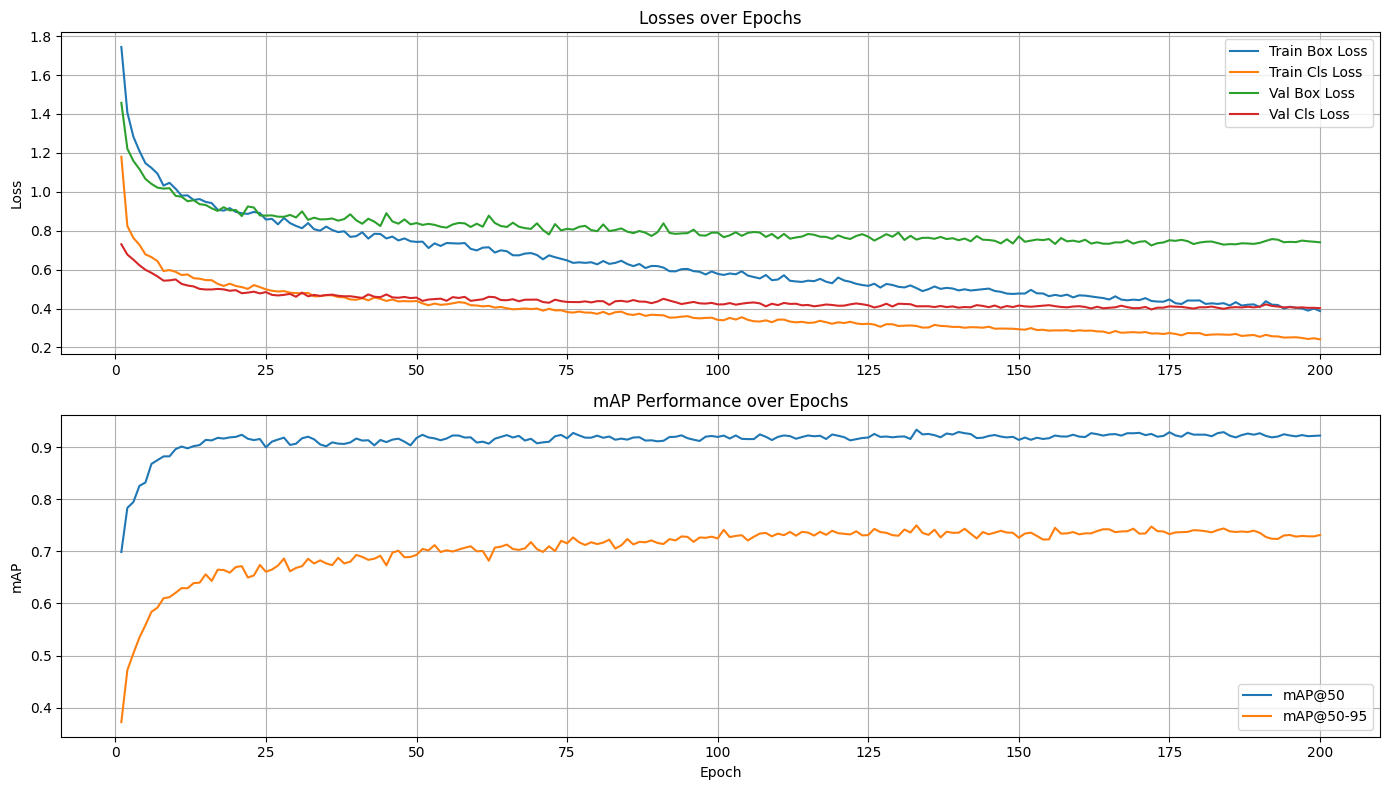

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(latest)

# Initialize lists to collect values
epochs = []
train_box_loss = []
train_cls_loss = []
val_box_loss = []
val_cls_loss = []
map50 = []
map5095 = []

# Collect data while printing
for i, row in df.iterrows():
    epochs.append(int(row['epoch']))
    train_box_loss.append(row['train/box_loss'])
    train_cls_loss.append(row['train/cls_loss'])
    val_box_loss.append(row['val/box_loss'])
    val_cls_loss.append(row['val/cls_loss'])
    map50.append(row['metrics/mAP50(B)'])
    map5095.append(row['metrics/mAP50-95(B)'])

    print(f"Epoch {int(row['epoch'])}: "
          f"Train Box Loss={row['train/box_loss']:.3f}, "
          f"Train Cls Loss={row['train/cls_loss']:.3f}, "
          f"Val Box Loss={row['val/box_loss']:.3f}, "
          f"Val Cls Loss={row['val/cls_loss']:.3f}, "
          f"mAP50={row['metrics/mAP50(B)']:.3f}, "
          f"mAP50-95={row['metrics/mAP50-95(B)']:.3f}")

# Now plot them
plt.figure(figsize=(14, 8))

# Losses
plt.subplot(2, 1, 1)
plt.plot(epochs, train_box_loss, label='Train Box Loss')
plt.plot(epochs, train_cls_loss, label='Train Cls Loss')
plt.plot(epochs, val_box_loss, label='Val Box Loss')
plt.plot(epochs, val_cls_loss, label='Val Cls Loss')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)

# mAP
plt.subplot(2, 1, 2)
plt.plot(epochs, map50, label='mAP@50')
plt.plot(epochs, map5095, label='mAP@50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Performance over Epochs')
plt.legend()
plt.grid(True)

# Save plots to Drive
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/metrics_summary.png")
print("plot saved to Drive.")
plt.show()


In [ ]:
import shutil
import os
import glob

# Automatically find the latest trainX folder
results_csv = sorted(
    glob.glob("/content/runs/detect/train*/results.csv"),
    key=os.path.getmtime
)[-1]  # get most recent CSV file

# Define save location
dst = "/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/results.csv"

# Copy it
shutil.copy(results_csv, dst)
print(f"✅ CSV copied from {results_csv} to {dst}")


✅ CSV copied from /content/runs/detect/train/results.csv to /content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/results.csv


#YOLOv8 Box Loss (CIoU Loss) Explained

The YOLOv8 box loss uses **CIoU Loss**, which considers:

- **IoU**: overlap between predicted and ground truth boxes  
- **Center distance**: how far apart the box centers are  
- **Aspect ratio**: how different the width/height ratios are


---

##CIoU Loss Formula

Let:
- **B**: predicted bounding box  
- **B<sub>gt</sub>**: ground truth box  
- **ρ(b, b<sub>gt</sub>)**: Euclidean distance between centers  
- **c**: diagonal length of the smallest enclosing box  
- **v**: aspect ratio penalty term  
- **α**: balancing factor

CIoU_loss = 1 - IoU + (ρ(b, b_gt)^2) / c^2 + α * v

Where:
- `IoU` = Intersection over Union
- `ρ²` = squared distance between centers
- `c²` = squared diagonal of the enclosing box
- `v` = aspect ratio difference penalty
- `α = v / (1 - IoU + v)`


CIoU loss evaluates how well the predicted bounding box aligns with the ground truth by combining:

- **Overlap**: it ensures the predicted box covers the object (via IoU)
- **Alignment**: it penalizes boxes whose centers are far from the object's center
- **Shape consistency**: it discourages mismatched aspect ratios (e.g., wide vs tall)

By combining these factors, CIoU encourages not just overlap, but also accurate position and shape — leading to more precise bounding box predictions.



#YOLOv8 Classification Loss (Cls Loss)

YOLOv8 uses Binary Cross-Entropy with logits (BCEWithLogitsLoss) for classification.

It treats each class prediction as a separate binary classification task using one-hot encoded targets.

---

Formula:
* BCE(p, y) = - [y * log(sigmoid(p)) + (1 - y) * log(1 - sigmoid(p))]

Where:
- p is the raw class prediction (logit)
- y is the ground truth (1 for correct class, 0 otherwise)

In PyTorch:
F.binary_cross_entropy_with_logits(pred, target)

---

What it measures:

- Encourages high confidence (p → 1) for the correct class (y = 1)
- Penalizes confident wrong predictions (p → 1 when y = 0)
- Trains each class independently (multi-label setup)

YOLOv8 uses this to guide the model to predict the correct class for each detected object.


# mAP@50 and mAP@50–95 (Mean Average Precision)

**mAP** stands for *Mean Average Precision*, a common metric to evaluate object detection models.

---

## What mAP Measures

It evaluates **how well the model detects and classifies objects**, based on:

- **Precision**: out of all predicted boxes, how many were correct?
- **Recall**: out of all ground truth boxes, how many did the model find?

For each class:
1. Sort predictions by confidence score.
2. Match predictions to ground truth boxes using an IoU threshold.
3. Compute the **Precision-Recall (PR) curve**.
4. Compute **AP = Area under the PR curve**.

Then:
- **mAP** = mean of APs over all classes.

---

## What is IoU (Intersection over Union)?

**IoU (Intersection over Union)** is a metric used in object detection to measure the overlap between the **predicted bounding box** and the **ground truth bounding box**.

---

### Formula:
**IoU = Area of Overlap / Area of Union**

- **IoU = 1** → perfect overlap  
- **IoU = 0** → no overlap  
- **0 < IoU < 1** → partial overlap  


## 🟩 mAP@50

- IoU threshold = **0.50**
- A predicted box is considered correct if it overlaps with a ground truth box by at least 50%.

This is a **lenient metric**, showing basic detection quality.

---

## 🟥 mAP@50–95

- Averages AP across **IoU thresholds from 0.50 to 0.95** (step = 0.05)
- This gives **10 scores**: AP@0.50, AP@0.55, ..., AP@0.95

Final score:
<details> <summary>
mAP@50-95 = mean([AP@0.50, AP@0.55, ..., AP@0.95])

This is the **stricter COCO-style** metric — it evaluates both detection accuracy and box precision.

---

**In short:**
- `mAP@50`: Did the model detect the object?
- `mAP@50-95`: Did it detect it *and* precisely localize it?





# YOLOv8 Training Graphs

* F1_curve.png: Shows the F1 score (balance between precision and recall) across different confidence thresholds. Peaks indicate the best confidence for performance.

* P_curve.png:
Displays Precision vs confidence. Higher precision means fewer false positives. A flat line near 1.0 is ideal.

* R_curve.png:
Shows Recall vs confidence. Higher recall means fewer false negatives. Good recall = most objects detected.

* confusion_matrix.png:
Visual summary of true vs predicted classes. Diagonal = correct predictions. Off-diagonal = mistakes.

* labels.jpg:
Heatmap and counts of labeled objects per class and image location. Helps visualize dataset balance and object placement.

* results.png:
Plots of training/validation loss and mAP scores across epochs. Useful to track convergence and model improvement.


In [ ]:
import os
import glob
import matplotlib.pyplot as plt

# Auto-detect the most recent training run that contains results
train_dirs = sorted(glob.glob("runs/detect/train*/"), key=os.path.getmtime, reverse=True)

# Pick the most recent directory that contains at least one plot image
train_dir = None
for d in train_dirs:
    if any(os.path.exists(os.path.join(d, f)) for f in ["F1_curve.png", "results.png", "labels.jpg"]):
        train_dir = d
        break

if train_dir is None:
    raise FileNotFoundError("No YOLO training run with result images found.")

print(f"Using training results from: {train_dir}")

# Filenames of training result plots
train_images = [
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "confusion_matrix.png",
    "labels.jpg",
    "results.png",
]


# Grid setup
num_images = len(train_images)
cols = 2
rows = (num_images + cols - 1) // cols  # ceiling division

# Bigger figure size (adjust if needed)
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 6))
axes = axes.flatten()

# Display each image in the grid
for i, img_name in enumerate(train_images):
    img_path = os.path.join(train_dir, img_name)
    if os.path.exists(img_path):
        print(f"Displaying: {img_name}")
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_name, fontsize=14)
    else:
        print(f"File not found: {img_name}")
        axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import glob
from IPython.display import Image, display

#  Auto-find latest training folder that has val images
train_dirs = sorted(glob.glob("runs/detect/train*/"), key=os.path.getmtime, reverse=True)

val_dir = None
for d in train_dirs:
    if any(os.path.exists(os.path.join(d, f)) for f in ["val_batch0_pred.jpg", "F1_curve.png"]):
        val_dir = d
        break

if val_dir is None:
    raise FileNotFoundError("No validation images found in any runs/detect/train*/ folder.")

print(f" Using validation results from: {val_dir}")

val_images = [
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "confusion_matrix.png",
    "labels.jpg",
    "results.png",
]
# Display images
for img_name in val_images:
    img_path = os.path.join(val_dir, img_name)
    if os.path.exists(img_path):
        print(f" Displaying: {img_name}")
        display(Image(filename=img_path))
    else:
        print(f"File not found: {img_name}")


In [ ]:
def create_image_txt_list(dataset_root, billboards, subset="test_nopatch"):
    """
    Appends all image paths from specified billboards and subset into a single txt list.
    """
    output_txt = os.path.join(dataset_root, f"{subset}.txt")

    with open(output_txt, "a") as f:
        for billboard in billboards:
            image_folder = os.path.join(dataset_root, billboard, "images", subset)
            if not os.path.exists(image_folder):
                print(f"⚠️ Warning: {image_folder} does not exist.")
                continue

            images = sorted([
                os.path.join(image_folder, file)
                for file in os.listdir(image_folder)
                if file.endswith((".jpg", ".png"))
            ])
            for img_path in images:
                f.write(img_path + "\n")


In [ ]:
def convert_all_test_sets(dataset_root, billboards, test_subfolders):
    for test_name in test_subfolders:
        # Clear the final txt once per test set
        txt_path = os.path.join(dataset_root, f"{test_name}.txt")
        open(txt_path, 'w').close()

        for billboard in billboards:
            print(f"\nProcessing {billboard} / {test_name}")
            convert_coco_to_yolo_per_folder(dataset_root, [billboard], subset=test_name)

        # After processing all billboards for this test set, collect image paths
        create_image_txt_list(dataset_root, billboards, subset=test_name)


In [ ]:
dataset_root = "/content/drive/MyDrive/2dod/2dod"

billboards = [
    "billboard01", "billboard02", "billboard03", "billboard04",
    "billboard05", "billboard06", "billboard07", "billboard08", "billboard09"
]

test_folders = ["test_nopatch", "test_frcnn", "test_random", "test_retinanet"]

convert_all_test_sets(dataset_root, billboards, test_folders)



Processing billboard01 / test_nopatch
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
billboard01: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_nopatch

Processing billboard02 / test_nopatch
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
billboard02: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard02/labels/test_nopatch

Processing billboard03 / test_nopatch
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
billboard03: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard03/labels/test_nopatch

Processing billboard04 / test_nopatch
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
billboard04: YOLO labels saved to /content/drive/MyDrive/2dod/2dod/billboard04/labels/test_nopatch

Processing billboard05 / test_nopatch
loading annotations into memory...
Done (t=0.00s)
creating index...
index cre

In [ ]:
yaml_content = """\
path: /content/drive/MyDrive/2dod/2dod/
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
test: test_nopatch.txt

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("/content/drive/MyDrive/2dod/2dod/test_nopatch.yaml", "w") as f:
    f.write(yaml_content)

print("test_nopatch.yaml created.")



test_nopatch.yaml created.


In [ ]:
yaml_content = """\
path: /content/drive/MyDrive/2dod/2dod/
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
test: test_frcnn.txt

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("/content/drive/MyDrive/2dod/2dod/test_frcnn.yaml", "w") as f:
    f.write(yaml_content)

print("test_frcnn.yaml created.")


test_frcnn.yaml created.


In [ ]:
yaml_content = """\
path: /content/drive/MyDrive/2dod/2dod/
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
test: test_random.txt

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("/content/drive/MyDrive/2dod/2dod/test_random.yaml", "w") as f:
    f.write(yaml_content)

print("test_random.yaml created.")

test_random.yaml created.


In [ ]:
yaml_content = """\
path: /content/drive/MyDrive/2dod/2dod/
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
test: test_retinanet.txt

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("/content/drive/MyDrive/2dod/2dod/test_retinanet.yaml", "w") as f:
    f.write(yaml_content)

print("test_retinanet.yaml created.")

test_retinanet.yaml created.


In [ ]:
test_sets = {
    "No Patch": "/content/drive/MyDrive/2dod/2dod/test_nopatch.yaml",
    "FRCNN": "/content/drive/MyDrive/2dod/2dod/test_frcnn.yaml",
    "Random": "/content/drive/MyDrive/2dod/2dod/test_random.yaml",
    "RetinaNet": "/content/drive/MyDrive/2dod/2dod/test_retinanet.yaml"
}


In [ ]:
test_results = {}

for name, yaml_path in test_sets.items():
    print(f"Evaluating {name}...")
    results = model.val(data=yaml_path, split="test")

    test_results[name] = {
      "mAP50": results.box.map50,
      "mAP50-95": results.box.map,
      "Precision": results.box.p,
      "Recall": results.box.r
}



Evaluating No Patch...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 498.3±42.0 MB/s, size: 1644.6 KB)


val: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_nopatch... 421 images, 29 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:08<00:00, 50.38it/s]


val: New cache created: /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_nopatch.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:04<00:00, 11.53it/s]


                   all        450       1814      0.873      0.886      0.904      0.716
                person        145        210      0.868      0.814      0.873      0.535
                   car        336        939      0.868      0.893      0.924      0.774
            motorcycle         30         76      0.845      0.684      0.788      0.591
                 truck         38         65      0.831          1      0.899      0.775
         traffic light        208        507      0.935       0.98      0.977       0.76
             stop sign         17         17       0.89      0.941      0.964      0.865
Speed: 0.3ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train48
Evaluating FRCNN...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 585.9±66.5 MB/s, size: 1715.6 KB)


val: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_frcnn... 421 images, 29 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:09<00:00, 45.69it/s]

val: New cache created: /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_frcnn.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:04<00:00, 11.40it/s]


                   all        450       1813      0.826      0.813      0.813      0.644
                person        145        210      0.733      0.548      0.565      0.333
                   car        336        938      0.791      0.809      0.778      0.623
            motorcycle         30         76      0.838      0.679      0.785      0.586
                 truck         38         65       0.83          1      0.906      0.784
         traffic light        208        507      0.873      0.898      0.879      0.672
             stop sign         17         17      0.892      0.941      0.964      0.864
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train49
Evaluating Random...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 595.1±84.1 MB/s, size: 1715.2 KB)


val: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_random... 421 images, 29 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:02<00:00, 156.31it/s]


val: New cache created: /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_random.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:04<00:00, 11.44it/s]


                   all        450       1816      0.882      0.873      0.902      0.711
                person        145        210      0.897      0.786      0.859      0.519
                   car        336        941       0.87      0.887      0.923      0.768
            motorcycle         30         76      0.846      0.671      0.787      0.587
                 truck         38         65      0.829          1      0.898      0.773
         traffic light        208        507      0.956      0.953      0.979      0.753
             stop sign         17         17      0.891      0.941      0.964      0.865
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train50
Evaluating RetinaNet...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 644.1±38.5 MB/s, size: 1827.4 KB)


val: Scanning /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_retinanet... 421 images, 29 backgrounds, 0 corrupt: 100%|██████████| 450/450 [00:02<00:00, 154.38it/s]


val: New cache created: /content/drive/MyDrive/2dod/2dod/billboard01/labels/test_retinanet.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:04<00:00, 11.45it/s]


                   all        450       1814       0.88      0.849      0.885        0.7
                person        145        210      0.912      0.642      0.755      0.455
                   car        336        939      0.864      0.883      0.921      0.768
            motorcycle         30         76      0.835      0.684      0.786      0.584
                 truck         38         65      0.829          1      0.907      0.785
         traffic light        208        507       0.96      0.942      0.977      0.742
             stop sign         17         17       0.88      0.941      0.964      0.865
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train51


In [ ]:
test_results["test_random"] = {
    "mAP50": results.box.map50,
    "mAP75": results.box.map75,     # This is mAP@0.75
    "mAP50-95": results.box.map,    # This is the mean mAP over IoU [.50:.95]
    "Precision": results.box.p,
    "Recall": results.box.r
}

# Print nicely
for k, v in test_results["test_random"].items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


mAP50: 0.8786
mAP75: 0.7730
mAP50-95: 0.6893
Precision: [    0.93007     0.95442     0.94973]
Recall: [    0.58824     0.93075     0.89978]


In [ ]:
from pprint import pprint

pprint(values)


NameError: name 'values' is not defined

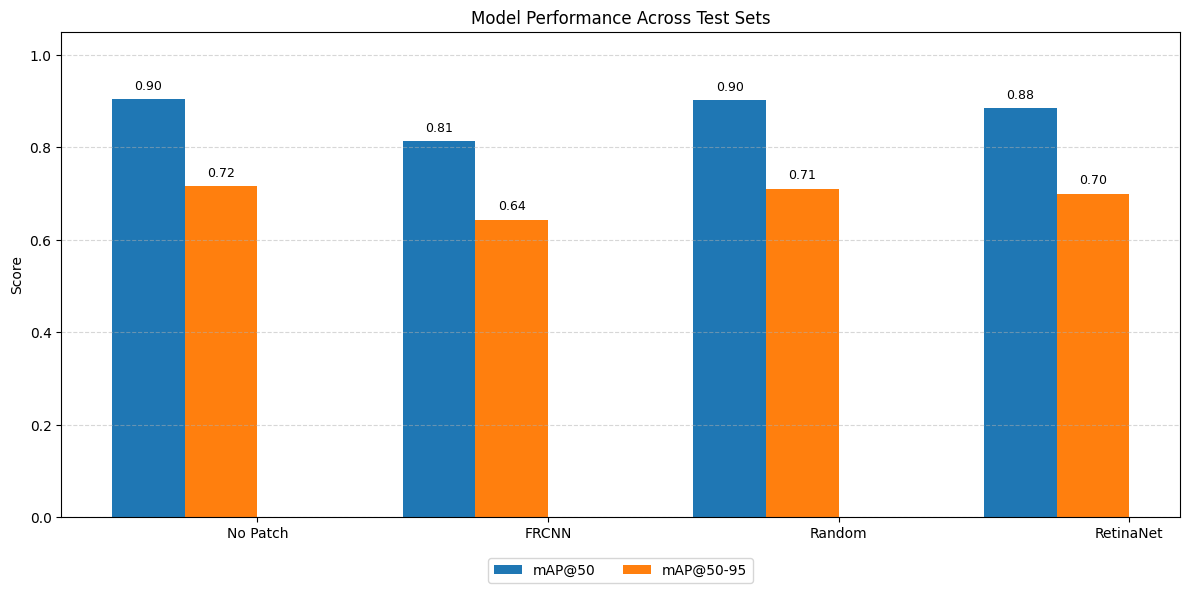

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(test_results.keys())
x = np.arange(len(labels))
width = 0.25

# Extract metrics in order of the labels
mAP50 = [test_results[key]["mAP50"] for key in labels]
mAP90 = [test_results[key]["mAP50-95"] for key in labels]

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
bars1 = ax.bar(x - 1.5*width, mAP50, width, label="mAP@50")
bars2 = ax.bar(x - 0.5*width, mAP90, width, label="mAP@50-95")


# Annotate each bar with its value
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, rotation=0)

for b in [bars1, bars2]:
    annotate_bars(b)

# Styling
ax.set_ylabel("Score")
ax.set_title("Model Performance Across Test Sets")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
